In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn import metrics
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [92]:
class Classifier:
    
    def __init__(self):
        pass
    
    def file_input(self,filename):
        data = pd.read_csv(filename,low_memory=False)
        return data
    
    def data_exploration_clicks(self,clicks):
        
        print("Clicks category explorations:")
        category_analaysis = clicks[(clicks['category'].isin(['S','0','1','2','3','4','5','6','7','8','9','10','11','12']))]
        print("Count of clicks against each category")
        print(category_analaysis['category'].value_counts())
        
        print("Top 10 Items having maximum clicks:")
        print(clicks['item_id'].value_counts().nlargest(10))
        
        
        
    def data_exploration_buys(self,data):
        
        print("Top 10 Items which have been bought the maximum.")
        print(buys['item_id'].value_counts().nlargest(10))
        
        print("Top 10 items which are purchased in larger quantities.")
        quantity_analysis = buys[['item_id','qty']].groupby('item_id').agg(total_quantity=pd.NamedAgg(column='qty',aggfunc=sum))
        print(quantity_analysis['total_quantity'].nlargest(10))
        
        
        print("Top 10 items Identifying the items having the maximum price.")
        print(buys[['item_id','price']].drop_duplicates().sort_values('price',ascending=False).nlargest(10,columns='price'))
        
    
    def transforming_buys(self,buys):
        
        grouped = buys.groupby("session")
        buys_g = pd.DataFrame(index=grouped.groups.keys())
        buys_g["items_bought"] = grouped.item_id.count()
        
        buys_g["is_buy"] = 1 #setting the label as 1 for the sessions in the buys data.
        
        buys_g.index.name = "session"
        
        return buys_g
        
        
    def transforming_clicks(self,clicks):
        #converting the timestamp into required date time format.
        clicks['timestamp'] = pd.to_datetime(clicks['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')
        
        clicks_new = clicks.groupby('session')['timestamp'].agg([min,max])
        clicks_new['dwell_time'] = clicks_new['max'] - clicks_new['min'] #cal the dwell time of the session.
        
        clicks_new['dwell_time_seconds'] = clicks_new['dwell_time'].dt.total_seconds() #converting dwell time into seconds
        
        clicks.loc[clicks['category'] == 'S',['category']] = -1
        
        grouped = clicks.groupby('session')
        clicks_new['total_clicks'] = grouped.item_id.count()
        
        #clicks_new['total_items'] = grouped.item_id.unique().apply(lambda x: len(x))
        
        #clicks_new['total_categories_visted'] = grouped.category.unique().apply(lambda x: len(x))
        
        #clicks_new['categories_visted'] = grouped.category.unique()
    
        #clicks_new['item_ids'] = grouped.item_id.unique()
        
        clicks_new['dayofweek'] = clicks_new['min'].dt.dayofweek
        
        clicks_new['dayofmonth'] = clicks_new['min'].dt.day
        
        clicks_new['hourofclick'] = clicks_new['min'].dt.hour
        
        b = [0,4,8,12,16,20,24]
        l = ['Late Night', 'Early Morning','Morning','Noon','Evening','Night']
        clicks_new['timeofday'] = pd.cut(clicks_new['hourofclick'], bins=b, labels=l, include_lowest=True)
        
        clicks_new["click_rate"] = clicks_new["total_clicks"] / clicks_new["dwell_time_seconds"]
        clicks_new.click_rate = clicks_new.click_rate.replace(np.inf, np.nan)
        clicks_new.click_rate = clicks_new.click_rate.fillna(0)
        
        return clicks_new
    
    def data_preparation(self,X,y):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
        
       # train_x = training_dataset.loc[:,~training_dataset.columns.isin(['is_buy'])]
       # train_y = training_dataset.loc[:,training_dataset.columns.isin(['is_buy'])]
       # test_x = testing_dataset.loc[:,~testing_dataset.columns.isin(['Target'])]
       # test_y = testing_dataset.loc[:,testing_dataset.columns.isin(['Target'])]
        return X_train, X_test, y_train, y_test
    
        
    def undersampling(self,train_data):   
        
        #train_data = pd.concat([X_train,y_train],axis=1)
        count_class_0, count_class_1 = train_data['is_buy'].value_counts()
        df_class_0 = train_data[train_data['is_buy'] == 0]
        df_class_1 = train_data[train_data['is_buy'] == 1]
        df_class_0_under = df_class_0.sample(count_class_1)
        df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
        df_test_under['is_buy'].value_counts()
        return df_test_under
        
    def one_hot_encode(self,column_name,training_data):
        temp = pd.get_dummies(training_data[column_name])
        training_data = pd.concat([training_data, temp], axis=1)
        return training_data
        
    def get_preds(self,threshold, probabilities):
        return [1 if prob > threshold else 0 for prob in probabilities]
        
    def logit_model(self,train_x,train_y,test_x,test_y,thres=0.5):
        model = LogisticRegression(solver='lbfgs')
        model.fit(train_x,train_y.values.ravel())
        probas = model.predict_proba(test_x)[:, 1]
        print("Threshold Value : ",thres)
        y_pred = self.get_preds(thres,probas)
        return y_pred,probas

    def error_metrics(self,prediction,test_y,probas):
        accuracy = accuracy_score(prediction,test_y)        
        error = sqrt(mean_squared_error(test_y,prediction)) 
        print('RMSE = ',error)
        print('Accuracy =',accuracy)
        print("")
        print(pd.DataFrame(confusion_matrix(test_y, prediction), columns=['Predicted 0', "Predicted 1"], index=['Actual 0', 'Actual 1']))
        print("classification_Report:")
        print(classification_report(test_y,prediction))
        fig, ax = plt.subplots(figsize=(10,7))
        fpr, tpr, threshold = metrics.roc_curve(test_y,probas,pos_label=1)
        i = np.arange(len(tpr)) 
        roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
        roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
        print("Optimum Threshold Value:",list(roc_t['threshold']))
        
        auc = metrics.roc_auc_score(test_y, probas)
        plt.plot(fpr,tpr,label="auc="+str(auc))
        ax.plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100),label='baseline',linestyle='--')
        plt.title('Receiver Operating Characteristic Curve', fontsize=18)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)
        plt.legend(fontsize=12);
        plt.show()
        

In [93]:
data = Classifier() 

In [16]:
clicks = data.file_input('/kaggle/input/recsys-challenge-2015/yoochoose-clicks.dat')

In [17]:
names=["session", "timestamp", "item_id", "category"]
clicks.columns = names

In [18]:
buys = data.file_input('/kaggle/input/recsys-challenge-2015/yoochoose-buys.dat')

In [19]:
names=["session", "timestamp", "item_id", "price", "qty"]
buys.columns = names

In [20]:
data.data_exploration_buys(buys)

Top 10 Items which have been bought the maximum.
643078800    15203
214829878     8081
214853420     5356
214829887     4788
214853102     4050
214821277     3586
214834880     3583
214834877     3574
214853094     3522
214844439     3411
Name: item_id, dtype: int64
Top 10 items which are purchased in larger quantities.
item_id
214853420    10226
214821277     8490
214853102     7507
214850947     6242
214821305     5435
214850949     4286
214854785     4286
214821290     3840
214853094     3589
214821302     3372
Name: total_quantity, dtype: int64
Top 10 items Identifying the items having the maximum price.
          item_id   price
793848  214712049  334998
819533  214600929  293111
789949  214587935  265883
97464   214587935  261695
14654   214587937  240751
41187   214835345  238656
34654   214537766  230279
97917   214509260  214571
55486   214696089  209335
75633   214700499  209335


In [21]:
data.data_exploration_clicks(clicks)

Clicks category explorations:
Count of clicks against each category
0     16337652
S     10769610
1      1671754
2      1292249
3       789713
4       480569
5       471923
6       414696
7       389910
9       105282
11       70264
10       69820
8        44840
12       19357
Name: category, dtype: int64
Top 10 Items having maximum clicks:
643078800    147419
214853094    125690
214829878    113488
214853420     78448
214826610     69710
214853096     66067
214748336     62150
214834880     61668
214839973     60332
214821309     55854
Name: item_id, dtype: int64


In [22]:
buys_g = data.transforming_buys(buys)

In [23]:
clicks_new = data.transforming_clicks(clicks)

In [24]:
clicks_new

,min,max,dwell_time,dwell_time_seconds,total_clicks,dayofweek,dayofmonth,hourofclick,timeofday,click_rate
session,,,,,,,,,,
1,2014-04-07 10:54:09.868,2014-04-07 10:57:00.306,00:02:50.438000,170.438,3,0,7,10,Morning,0.017602
2,2014-04-07 13:56:37.614,2014-04-07 14:02:36.889,00:05:59.275000,359.275,6,0,7,13,Noon,0.016700
3,2014-04-02 13:17:46.940,2014-04-02 13:30:12.318,00:12:25.378000,745.378,3,2,2,13,Noon,0.004025
4,2014-04-07 12:09:10.948,2014-04-07 12:26:25.416,00:17:14.468000,1034.468,2,0,7,12,Morning,0.001933
6,2014-04-06 16:58:20.848,2014-04-06 17:02:26.976,00:04:06.128000,246.128,2,6,6,16,Noon,0.008126
...,...,...,...,...,...,...,...,...,...,...
11562156,2014-09-26 04:42:16.616,2014-09-26 04:45:08.405,00:02:51.789000,171.789,2,4,26,4,Late Night,0.011642
11562157,2014-09-25 12:31:10.391,2014-09-25 12:31:29.679,00:00:19.288000,19.288,2,3,25,12,Morning,0.103691
11562158,2014-09-26 04:50:29.172,2014-09-26 05:16:32.904,00:26:03.732000,1563.732,3,4,26,4,Late Night,0.001918


In [32]:
training_data = pd.merge(clicks_new,buys_g['is_buy'],how='left',left_index=True,right_index=True)
training_data['is_buy'] = training_data['is_buy'].fillna(0)

In [33]:
training_data

,min,max,dwell_time,dwell_time_seconds,total_clicks,dayofweek,dayofmonth,hourofclick,timeofday,click_rate,is_buy
session,,,,,,,,,,,
1,2014-04-07 10:54:09.868,2014-04-07 10:57:00.306,00:02:50.438000,170.438,3,0,7,10,Morning,0.017602,0.0
2,2014-04-07 13:56:37.614,2014-04-07 14:02:36.889,00:05:59.275000,359.275,6,0,7,13,Noon,0.016700,0.0
3,2014-04-02 13:17:46.940,2014-04-02 13:30:12.318,00:12:25.378000,745.378,3,2,2,13,Noon,0.004025,0.0
4,2014-04-07 12:09:10.948,2014-04-07 12:26:25.416,00:17:14.468000,1034.468,2,0,7,12,Morning,0.001933,0.0
6,2014-04-06 16:58:20.848,2014-04-06 17:02:26.976,00:04:06.128000,246.128,2,6,6,16,Noon,0.008126,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11562156,2014-09-26 04:42:16.616,2014-09-26 04:45:08.405,00:02:51.789000,171.789,2,4,26,4,Late Night,0.011642,0.0
11562157,2014-09-25 12:31:10.391,2014-09-25 12:31:29.679,00:00:19.288000,19.288,2,3,25,12,Morning,0.103691,0.0
11562158,2014-09-26 04:50:29.172,2014-09-26 05:16:32.904,00:26:03.732000,1563.732,3,4,26,4,Late Night,0.001918,0.0


In [34]:
training_data[training_data['is_buy'] == 1]['dwell_time_seconds'].mean()

867.1085169670088

In [35]:
training_data[training_data['is_buy'] == 0]['dwell_time_seconds'].mean()

353.321709638942

In [37]:
training_data_temp = training_data[training_data['is_buy'] == 0]

In [38]:
training_data_temp['dayofweek'].value_counts()

6    1838937
0    1782902
2    1300944
3    1246708
5     976275
4     970333
1     623934
Name: dayofweek, dtype: int64

In [39]:
training_data_temp = training_data[training_data['is_buy'] == 1]

In [40]:
training_data_temp['dayofweek'].value_counts()

6    122455
0     99038
5     72219
3     68632
2     68324
4     58127
1     20901
Name: dayofweek, dtype: int64

In [41]:
training_data_temp['timeofday'].value_counts()

Evening          138899
Morning          128436
Noon             124435
Early Morning     92709
Night             17151
Late Night         8066
Name: timeofday, dtype: int64

In [42]:
training_data['is_buy'].value_counts()

0.0    8740033
1.0     509696
Name: is_buy, dtype: int64

In [43]:
updated_training_data = data.one_hot_encode("timeofday",training_data)

In [44]:
updated_training_data

,min,max,dwell_time,dwell_time_seconds,total_clicks,dayofweek,dayofmonth,hourofclick,timeofday,click_rate,is_buy,Late Night,Early Morning,Morning,Noon,Evening,Night
session,,,,,,,,,,,,,,,,,
1,2014-04-07 10:54:09.868,2014-04-07 10:57:00.306,00:02:50.438000,170.438,3,0,7,10,Morning,0.017602,0.0,0,0,1,0,0,0
2,2014-04-07 13:56:37.614,2014-04-07 14:02:36.889,00:05:59.275000,359.275,6,0,7,13,Noon,0.016700,0.0,0,0,0,1,0,0
3,2014-04-02 13:17:46.940,2014-04-02 13:30:12.318,00:12:25.378000,745.378,3,2,2,13,Noon,0.004025,0.0,0,0,0,1,0,0
4,2014-04-07 12:09:10.948,2014-04-07 12:26:25.416,00:17:14.468000,1034.468,2,0,7,12,Morning,0.001933,0.0,0,0,1,0,0,0
6,2014-04-06 16:58:20.848,2014-04-06 17:02:26.976,00:04:06.128000,246.128,2,6,6,16,Noon,0.008126,0.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11562156,2014-09-26 04:42:16.616,2014-09-26 04:45:08.405,00:02:51.789000,171.789,2,4,26,4,Late Night,0.011642,0.0,1,0,0,0,0,0
11562157,2014-09-25 12:31:10.391,2014-09-25 12:31:29.679,00:00:19.288000,19.288,2,3,25,12,Morning,0.103691,0.0,0,0,1,0,0,0
11562158,2014-09-26 04:50:29.172,2014-09-26 05:16:32.904,00:26:03.732000,1563.732,3,4,26,4,Late Night,0.001918,0.0,1,0,0,0,0,0


In [45]:
updated_training_data = updated_training_data.loc[:,~updated_training_data.columns.isin(['min','max','timeofday','dwell_time'])]

In [49]:
updated_training_data['is_buy'].value_counts()

0.0    8740033
1.0     509696
Name: is_buy, dtype: int64

In [46]:
new_balanced_data = data.undersampling(updated_training_data)

In [47]:
new_balanced_data['is_buy'].value_counts()

1.0    509696
0.0    509696
Name: is_buy, dtype: int64

In [50]:
new_balanced_data.head()

,dwell_time_seconds,total_clicks,dayofweek,dayofmonth,hourofclick,click_rate,is_buy,Late Night,Early Morning,Morning,Noon,Evening,Night
session,,,,,,,,,,,,,
6045272,610.334,8,6,13,15,0.013108,0.0,0,0,0,1,0,0
5935839,0.000,1,4,11,13,0.000000,0.0,0,0,0,1,0,0
6733086,2302.052,3,2,23,9,0.001303,0.0,0,0,1,0,0,0
7873054,705.053,6,6,10,6,0.008510,0.0,0,1,0,0,0,0
9468173,0.000,1,3,28,7,0.000000,0.0,0,1,0,0,0,0


In [80]:
X = new_balanced_data.loc[:,~new_balanced_data.columns.isin(['is_buy'])]
y = new_balanced_data.loc[:,new_balanced_data.columns.isin(['is_buy'])]

In [81]:
X_train, X_test, y_train, y_test = data.data_preparation(X,y)

In [95]:
pred,prob = data.logit_model(X_train,y_train,X_test,y_test,0.44)

Threshold Value :  0.44


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [84]:
y_test.astype({'is_buy': 'int32'}).dtypes

is_buy    int32
dtype: object

In [88]:
y_test['is_buy'] = pd.to_numeric(y_test['is_buy'], downcast='signed')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [90]:
y_test

,is_buy
session,
1259351,0
670567,1
7002864,1
10929757,1
5301689,1
...,...
8288267,0
510859,0
1376021,0


RMSE =  0.5764915909567029
Accuracy = 0.6676574455562095

            Predicted 1.0  Predicted 2.0
Actual 1.0          33339          17597
Actual 2.0          16282          34722
classification_Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     50936
           1       0.66      0.68      0.67     51004

    accuracy                           0.67    101940
   macro avg       0.67      0.67      0.67    101940
weighted avg       0.67      0.67      0.67    101940

Optimum Threshold Value: [0.44413383799088063]


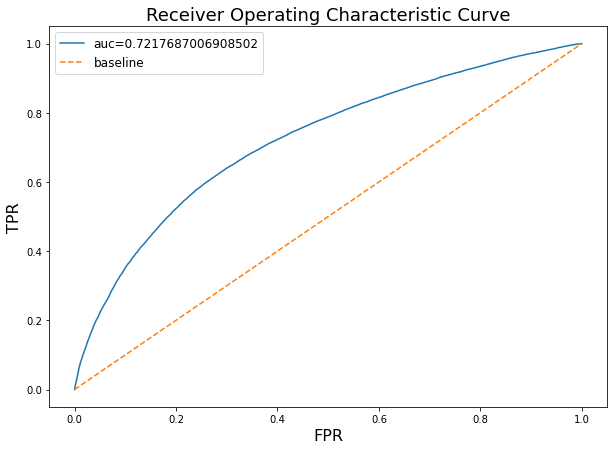

In [96]:
data.error_metrics(pred,y_test['is_buy'],prob)

In [68]:
probs

NameError: name 'probs' is not defined